# Second Practical work

## Authors:

**Full name:** Mireia Alba Kesti Izquierdo 
    
**NIA**:** 100406960

**Full name:** Aleksandra Jamróz
    
**NIA**:** 100491363

This second practical work skeleton is divided in 4 parts:
1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data
4.   GPU load

## Module load section
We will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

As well we load numpy and matplotlib modules.

In [129]:
# !pip install pycuda

We import the Python modules which we will use in the notebook (numpy, pycuda and time module) 

In [130]:
import  numpy  as  np
import  pycuda.autoinit
from    pycuda.compiler import SourceModule
import  pycuda.driver as  drv
import  pycuda.gpuarray as  gpuarray
from    sys import getsizeof
import  time

In [131]:
%pylab inline
from    PIL import Image
import  matplotlib.pyplot as plt
import  matplotlib.image as mpimg
import  cProfile

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Mount Google Drive and access grant
We use Google API to allow access to our Google Drive.

For security and privacy reasons, this permission is temporally, and will be requested every time you restart the notebook. 

Your Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive".

You have to copy your images to a folder in the "My Drive" folder in your Google Drive.

To check your available files, use the cell indicated as "**List Files in Folder**"

In [132]:
from os.path import join
# from google.colab import drive
# drive.mount("/content/drive")

In [133]:
# local env:
MYDRIVE = "../project 1/Filtered_Images"

# google colab:
# MYDRIVE="/content/drive/My Drive/"

**List Files in Folders**

In [134]:
# !ls /content/drive/My\ Drive/images

We define a variable IMAGE which is constructed joining the "MYDRIVE" varible plus the final path to your image.

In [135]:
# defining the images for filtering
chess_file = "chess.jpg"
digits_file = "digits.jpg"
fence_file = "fence.jpg"
hand_x_ray_file = "hand-x-ray.jpg"
jupiter_file = "cloudsonjupi.jpg"

IMAGE = join(MYDRIVE, chess_file)

In [136]:
print("Image to load: {0}".format(IMAGE))

Image to load: ../project 1/Filtered_Images/chess.jpg


Loads an image in a numpy variable, and show.

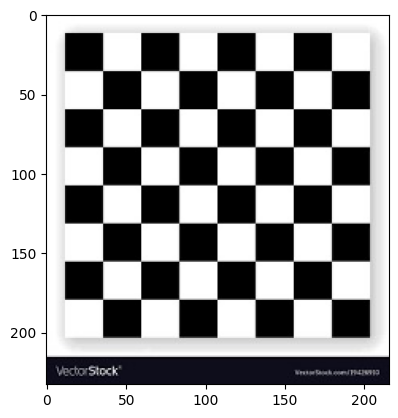

In [137]:
image = np.array(Image.open(IMAGE))
plt.figure()
plt.imshow(image)

# FILTER KERNEL

Here you have to define your image_filter GPU kernel.

In [138]:
kernel  =  SourceModule ("""
__global__ void image_filter( float * image,          //Source GPU array floating point 32 bits,
		                          float * filter_mask,    //Filter Mask GPU array 2D floating point 32 bits
                              float * filtered_image, //Target GPU array 2D floating point 32 bits,
                              int NumRowsImg,         //Image Numrows,
                              int NumColsImg,         //Int32 Image Numcolumns,
                              int NumRowsFilter,      //Int32 Image NumRows filter mask,
                              int NumColsFilter       //Int32 Image NumCols filter mask
                              ) 
{ 

// calculating how many rows & cols we have to take
int additional_rows_number = (NumRowsFilter-1)/2; 
int additional_cols_number = (NumColsFilter-1)/2; 

// define shared memory for sub-matrix of an image layer
__shared__ float ds_layer[%(BLOCK_SIZE)s * %(BLOCK_SIZE)s];

// define thread indexes 
const uint tx = threadIdx.x;
const uint ty = threadIdx.y;

// define several indexes 
int col = blockIdx.x * %(TILE_SIZE)s + tx ;
int row = blockIdx.y * %(TILE_SIZE)s + ty ; 

int row_i = row - additional_rows_number; 
int col_i = col - additional_cols_number;

// fill the tile memory 
if (row_i < NumRowsImg && row_i >=0 && col_i < NumColsImg && col_i >= 0)
  ds_layer[ty * blockDim.x + tx] = image[col_i + row_i * NumColsImg]; 
else 
  ds_layer[ty * blockDim.x + tx] = 0;                        

// synchronize to make sure the image is loaded
__syncthreads();

// Computing of the filter itself 

float temp = 0.0f; 

if (ty < %(TILE_SIZE)s && tx < %(TILE_SIZE)s)
{ 
  temp = 0; 
  for (int i = 0; i < NumRowsFilter ; i++)
  
    for (int j = 0; j < NumColsFilter ; j++)
    { 
      temp += filter_mask[j + i * NumColsFilter] * ds_layer[(ty + i)* blockDim.x + (tx + j)];
    }
  }
  if (row < NumRowsImg && col < NumColsImg)
  {
    filtered_image[col + row * NumColsImg] = temp; 
  }    
}  


}

""")

# default content:

# kernel  =  SourceModule ("""
# __global__ void image_filter( float * image,          //Source GPU array floating point 32 bits,
# 		                          float * filter_mask,    //Filter Mask GPU array 2D floating point 32 bits
#                               float * filtered_image, //Target GPU array 2D floating point 32 bits,
#                               int NumRowsImg,         //Image Numrows,
#                               int NumColsImg,         //Int32 Image Numcolumns,
#                               int NumRowsFilter,      //Int32 Image NumRows filter mask,
#                               int NumColsFilter       //Int32 Image NumCols filter mask
#                               ) 
# { 
#     //This instruction calculate in the offset in the memory data, based on the block identificator blockIdx.x
#     // YOU HAVE TO WRITE HERE YOUR FILTER KERNEL USING TILED MEMORY ALGORITHMS

#     //THIS CODE JUST COPY THE SOURCE IMAGE IN THE TARGET VECTOR
#     int idxY;
#     int idxX;
#     int vX;

#     idxY = blockIdx.y*blockDim.y+threadIdx.y; //With this we calculate the row address in target matrix
#     idxX = blockIdx.x*blockDim.x+threadIdx.x;
#     if ((idxY<NumRowsImg) && (idxX<NumColsImg)){
#       vX=idxY*NumColsImg+idxX;
#       filtered_image[vX]=image[vX];
#     }
# }

# """)


CompileError: nvcc compilation of /tmp/tmp6kenoyxw/kernel.cu failed
[command: nvcc --cubin -arch sm_61 -I/home/yamroza/anaconda3/envs/karoljestsuper/lib/python3.10/site-packages/pycuda/cuda kernel.cu]
[stderr:
kernel.cu(18): error: expected an expression

kernel.cu(25): error: expected an expression

kernel.cu(26): error: expected an expression

kernel.cu(44): error: expected an expression

kernel.cu(64): error: expected a declaration

5 errors detected in the compilation of "kernel.cu".
]

Recover the image shape, and select the two first items (rows and columns).

In [ ]:
image_shape = image.shape[0:2]

Set block size and grid size.

In [ ]:
TILE_SIZE = 12
BLOCK_SIZE = 16 
block_size = (BLOCK_SIZE, BLOCK_SIZE, 1)
grid_size = (int(np.ceil(image_shape[1]/TILE_SIZE)),int(np.ceil(image_shape[0]/TILE_SIZE)))


# block_s = 16
# block_size = (block_s, block_s,1)
# grid_size = (int(np.ceil(image_shape[1]/block_s)),int(np.ceil(image_shape[0]/block_s)))

In [ ]:
# get the kernel code from the template by specifying the constant

kernel = kernel % { 'TILE_SIZE': TILE_SIZE, 'BLOCK_SIZE': BLOCK_SIZE }

And import the kernel definition to python

In [ ]:
image_filter = kernel.get_function ('image_filter')

Allocate the target image memory.

In [ ]:
result_image = np.zeros(image.shape,dtype=np.uint8)

Define number of layers in the image

In [ ]:
depth = image.shape[2]

Here we define our sample filter masks.

In [ ]:
# definitions of 5 available filters as numpy arrays

filter1 = np.array([[0,0,0,0,0],
                    [0,0,0,0,0],
                    [0,0,1,0,0],
                    [0,0,0,0,0],
                    [0,0,0,0,0]])

filter2 = np.array([[0.5, 0 , -0.5]])

filter3 = np.array([[0.5],[0],[-0.5]])

filter4 = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]])

filter5 = np.array([[0.00078633,0.00655965,0.01330373,0.00655965,0.00078633],
                    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
                    [0.01330373,0.11098164,0.22508352,0.11098164,0.01330373],
                    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
                    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633]])

We select the filter mask, and upload to the GPU device.

In [ ]:
filter_mask = filter2.astype(np.float32)
filter_mask_gpu = gpuarray.to_gpu(filter_mask)

## Preparation of the execution environment 

Allocate the temporal filtered memory layer, where will be store the filtered image.

In [ ]:
filtered_image_layer_gpu = gpuarray.zeros(image_shape,np.float32)

Here we define the main block.
It NumColsImglks through the layers, copying the selected layer to temporal image_layer, uploading the layer to the GPU and invoking the image_filter kernel on it.

In [ ]:
start_t = time.time()
for layer in range(depth):
  image_layer = np.zeros(image_shape,dtype=np.float32) #Allocate the temporal image layer
  image_layer=(image[:,:,layer]).astype(np.float32)    #Copy from the orignal image the selected layer into the temporal memory
  image_layer_gpu=gpuarray.to_gpu(image_layer)         #Uploads the image layer to the GPU
  filtered_image_layer_gpu.fill(0.0)                   #Fills with 0 the target memory in the GPU
  image_filter(                                        #invokes the kernel
          image_layer_gpu,
          filter_mask_gpu,
          filtered_image_layer_gpu,
          np.int32(image_shape[0]),
          np.int32(image_shape[1]),
          np.int32(filter_mask.shape[0]),
          np.int32(filter_mask.shape[1]),
          block=block_size,
          grid=grid_size
        )
  filtered_image_layer=filtered_image_layer_gpu.get() #Download from the GPU the filtered image
  result_image[:,:,layer] = filtered_image_layer.astype(np.uint8) #Copy the filtered image to the final image store, 
                                                                  #casting the data type from double to uint8
end_t = time.time()

# Show results


In [ ]:
print("Execution time is: {0} seconds.".format(end_t-start_t))

In [ ]:
plt.figure()
plt.imshow(result_image)